# Pong Analysis: Experiment 5

Analyse the information captured during Experiment 5 to try and identify issues preventing the evolution of successful agents.

## Setup

In [1]:
import pickle
import os
import re

import numpy as np
import gym
from atariari.benchmark.wrapper import AtariARIWrapper
import neat

# Visualisation libraries
from IPython.display import HTML, Video
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import networkx as nx
import moviepy.editor as mpy

from custom_neat.nn.recurrent import RNN
from custom_neat.genome import Genome
from custom_neat.species import Species, SpeciesSet
from custom_neat.config import CustomConfig
from custom_neat.reproduction import Reproduction

In [2]:
matplotlib.rcParams['figure.dpi'] = 300

In [3]:
BASE_DIR = '../experiments/pong/pong_5/'

## Experiment Configuration

A copy of the experiment configuration used.

## Measuring Progress

Visualise the progress made towards the goal (reaching the fitness threshold) as evolution proceeds.

### Plot the best and average fitness over time for each run

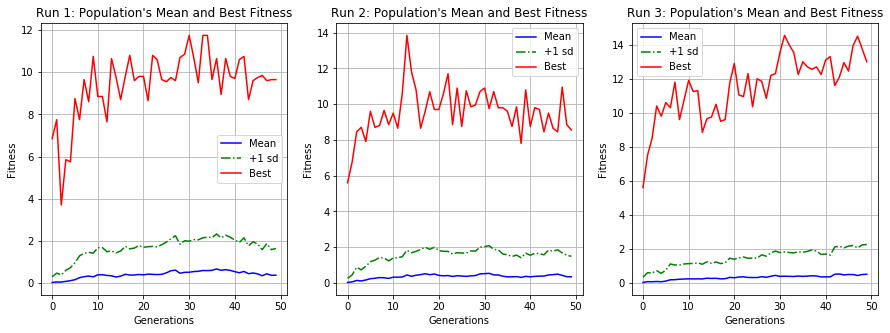

In [4]:
%matplotlib inline

n_subplots = 3
cols = 3
rows = n_subplots // cols + n_subplots % cols
plt_position = range(1, n_subplots + 1)
fig = plt.figure(1, figsize=(15, 5))

for k in range(n_subplots):
    # Load statistics reporter
    stats = pickle.load(open(BASE_DIR + f'run_{k + 1}/stats_reporter.pickle', 'rb'))

    # Gather statistics
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes]
    avg_fitness = np.array(stats.get_fitness_mean())
    stdev_fitness = np.array(stats.get_fitness_stdev())
    
    # Plot
    ax = fig.add_subplot(rows, cols, plt_position[k])

    plt.plot(generation, avg_fitness, 'b-', label='Mean')
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label='+1 sd')
    plt.plot(generation, best_fitness, 'r-', label='Best')

    plt.title(f"Run {k + 1}: Population's Mean and Best Fitness")
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(loc='best')

plt.subplots_adjust(hspace=0.4)
plt.show()

**Notes**

* The trend in both the best and mean fitness is similar to what was observed in previous experiments. In each run, the fitness tends to plateau early, and increases in the best fitness do not appear to lead to increases in the mean fitness of the population.
* My expectation is that the mean fitness should increase as evolution proceeds. This is because the best individuals are chosen for reproduction, and they should produce offspring that are better or similarly performing to themselves.
* The extreme 'spiking' nature of the best fitness line suggests that the measure of fitness is not representative of the true quality of the solutions. If it is representative then the best fitness should not reduce because elitism dictates the the best performing individuals are copied over unaltered.


* Possible causes for the observed behaviour:
    * The mutation operators are too aggressive, producing low performing children even when the parent(s) are high performing.
    * Too many low performing solutions are being carried over or being used as parents for the next generation, resulting in a new population that are the offspring of primarily low performing solutions.
        * However, only the top 10% of the population are chosen to be the parents for the next generation, which seems reasonable.
    * The measure of fitness (average score obtained over 20 episodes) is not representative of the true quality of the solution.
        * This has already been increased from an average over 10 episdoes.
        * Evaluations are expensive and averaging over any more episodes is infeasible.

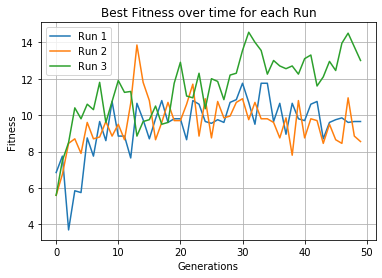

In [5]:
%matplotlib inline

for run in range(1, 4):
    # Load statistics reporter
    stats = pickle.load(open(BASE_DIR + f'run_{run}/stats_reporter.pickle', 'rb'))

    # Gather statistics
    generation = range(len(stats.most_fit_genomes))
    best_fitness = [c.fitness for c in stats.most_fit_genomes]
    avg_fitness = np.array(stats.get_fitness_mean())
    stdev_fitness = np.array(stats.get_fitness_stdev())
    
    # Plot
    plt.plot(generation, best_fitness, label=f'Run {run}')

    plt.title(f'Best Fitness over time for each Run')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.grid()
    plt.legend(loc='best')

plt.show()

**Notes**

* Overlaying the best fitness trend for each run highlights the difference between runs 1 and 2 and Run 3. The fitness in Run 3 appears to still be increasing at the 50th generation.

### Distribution of fitness over time

In [6]:
class RunLoader():
    """Lazy-load population checkpoints from an evolutionary run.
    
    Why bother? Lazy-loading prevents gobbling up all of the RAM.
    """

    def __init__(self, checkpoint_dir):
        """
        """
        self.checkpoint_dir = checkpoint_dir
        self.checkpoints = os.listdir(checkpoint_dir)
        self.checkpoints.sort(key=lambda x: int(re.sub("\D", "", x)))
        
        self.index = 0
        
    def __iter__(self):
        return self
            
    def __next__(self):
        """Return the next checkpoint in the checkpoints directory.
        """
        if self.index < len(self.checkpoints):
            filename = self.checkpoints[self.index]
            checkpoint_path = os.path.join(self.checkpoint_dir, filename)
            population = neat.Checkpointer.restore_checkpoint(checkpoint_path)
            self.index += 1
            
            return population
        else:
            self.index = 0
            raise StopIteration

In [7]:
%%capture

run1 = RunLoader(os.path.join(BASE_DIR, 'run_1/checkpoints/'))
run2 = RunLoader(os.path.join(BASE_DIR, 'run_2/checkpoints/'))
run3 = RunLoader(os.path.join(BASE_DIR, 'run_3/checkpoints/'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

def update(i):
    data1 = [g.fitness for g in next(run1).population.values() if g.fitness is not None]
    data2 = [g.fitness for g in next(run2).population.values() if g.fitness is not None]
    data3 = [g.fitness for g in next(run3).population.values() if g.fitness is not None]
    
    for i, (ax, data) in enumerate(((ax1, data1), (ax2, data2), (ax3, data3)), start=1):
        ax.clear()
        ax.set_xlim((0, 21))
        ax.set_ylim((0, 1))
        ax.set_xticks(range(0, 21, 5))
        ax.hist(data, normed=True, bins=range(22), alpha=0.5)
        
        if i == 1:
            ax.set_ylabel('Proportion of Individuals')
        if i == 2:
            ax.set_xlabel('Fitness (Score)')

anim = animation.FuncAnimation(fig, update, frames=48, repeat=False)

fig.suptitle('Population Fitness Distribution Over Time for each Run')
plt.subplots_adjust(wspace=0.3)
plt.show()

In [8]:
HTML(anim.to_jshtml())

**Notes**

* The fitness distribution does not shift to the right over time, indicating no real improvement in the individuals as evolution proceeds. Ideally, we would see the distribution gradually shift to the right as the population improves.
* This is a clearer demonstration of the lack of learning occuring. Individuals of higher fitness appear to be 'lucky' rather than as a result of gradual improvement in solution quality.

## Measuring Species Progress

The lack of learning demonstrated above raises the question of whether this holds true for all species. Alternatively, the fitness of some species may improve over time only to stagnate and die off.

### Species fitness per generation

A species' fitness is the fitness of the best individual in that species.

*TODO: Add mean species fitness to each plot.*

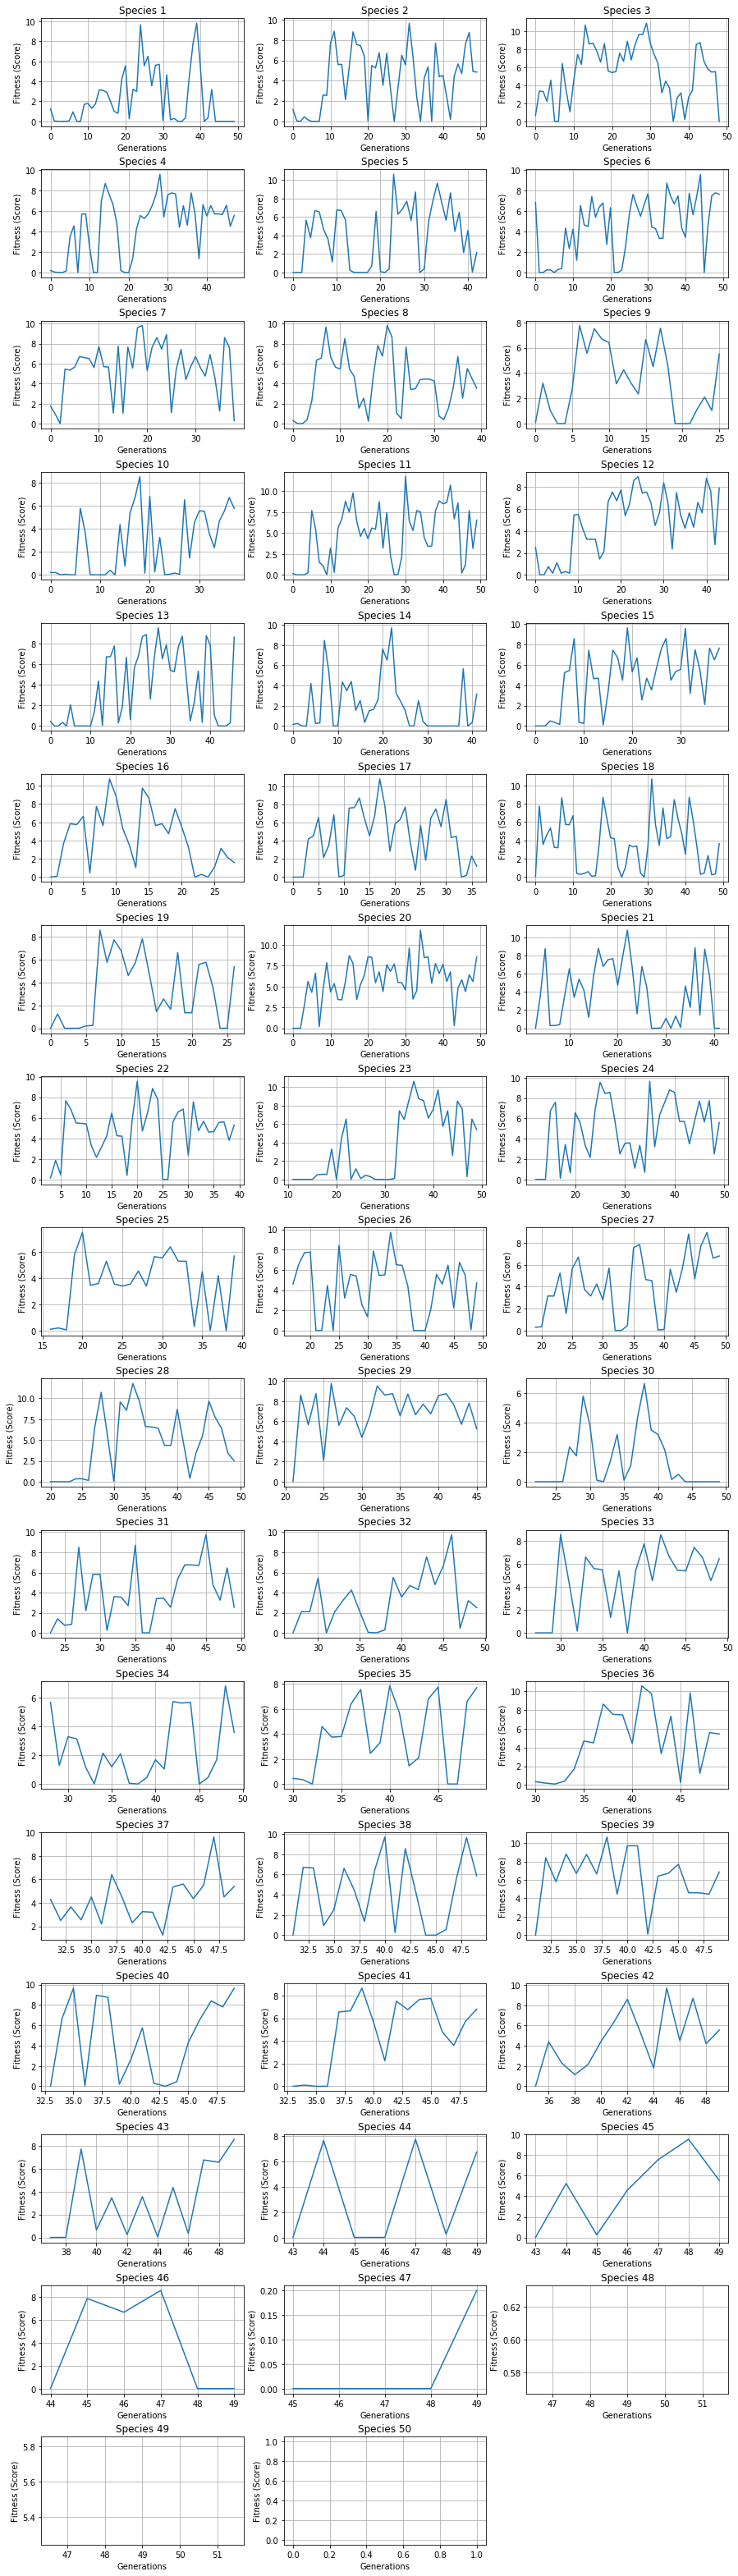

In [9]:
%matplotlib inline

# Load run
run = RunLoader(os.path.join(BASE_DIR, 'run_1/checkpoints/'))

# Get species keys
species_keys = sorted(list(set(k for pop in run for k in pop.species.species.keys())))

n_subplots = len(species_keys)
cols = 3
rows = n_subplots // cols + n_subplots % cols
plt_position = range(1, n_subplots + 1)
fig = plt.figure(1, figsize=(15, 60))

for i in range(n_subplots):
    # Get species fitness at each generation it was present
    key = species_keys[i]
    fitnesses = []
    generations = []
    for population in run:
        species = population.species.species.get(key)
        if species:
            generations.append(population.generation)
            fitnesses.append(species.fitness) 
    
    # Plot
    ax = fig.add_subplot(rows, cols, plt_position[i])
    plt.plot(generations, fitnesses, label='Best')

    plt.title(f"Species {i + 1}")
    plt.xlabel('Generations')
    plt.ylabel('Fitness (Score)')
    plt.grid()

plt.subplots_adjust(hspace=0.4)
plt.show()

### Species fitness distribution per generation

Visualise the fitness distributions of the species that the best individual of each evolutionary run belongs to.

In [10]:
# Get the species keys for the most common species the solutions were members of
n_runs = 3
species_keys = []

for i in range(1, n_runs + 1):
    run = RunLoader(os.path.join(BASE_DIR, f'run_{i}/checkpoints/'))
    solution = pickle.load(open(BASE_DIR + f'run_{i}/solution.pickle', 'rb'))
    species_keys.append([])
    
    # Find all species the solution was a member of
    for population in run:
        for key, species in population.species.species.items():
            if solution in species.members.values():
                species_keys[i-1].append(key)
                
# Select the most common species the solutions were members of 
species_keys = [max(set(l), key=l.count) for l in species_keys]
species_keys

[39, 32, 30]

In [11]:
%%capture

run1 = RunLoader(os.path.join(BASE_DIR, 'run_1/checkpoints/'))
run2 = RunLoader(os.path.join(BASE_DIR, 'run_2/checkpoints/'))
run3 = RunLoader(os.path.join(BASE_DIR, 'run_3/checkpoints/'))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

def update(i):
    population = next(run1)
    species = population.species.species.get(species_keys[0])
    data1 = [g.fitness for g in species.members.values() if g.fitness is not None] if species else []
    
    population = next(run2)
    species = population.species.species.get(species_keys[1])
    data2 = [g.fitness for g in species.members.values() if g.fitness is not None] if species else []
    
    population = next(run3)
    species = population.species.species.get(species_keys[2])
    data3 = [g.fitness for g in species.members.values() if g.fitness is not None] if species else []
    
    for j, (ax, data) in enumerate(((ax1, data1), (ax2, data2), (ax3, data3)), start=1):
        ax.clear()
        ax.set_xlim((0, 21))
        ax.set_ylim((0, 1))
        ax.set_xticks(range(0, 21, 5))
        ax.hist(data, normed=True, bins=range(22), alpha=0.5)
        
        if j == 1:
            ax.set_ylabel('Proportion of Individuals')
        if j == 2:
            ax.set_xlabel('Fitness (Score)')
            ax.set_title(f'Generation {i}')

anim = animation.FuncAnimation(fig, update, frames=48, repeat=False)

fig.suptitle('Population Fitness Distribution Over Time for each Run')
plt.subplots_adjust(wspace=0.3)
plt.show()

In [12]:
HTML(anim.to_jshtml())

## Robustness

Investigate the variability in the fitness of the best individual found in each run.

In [13]:
# Load solutions found by each run
n_runs = 3
solutions = []
for i in range(1, n_runs + 1):
    solution = pickle.load(open(BASE_DIR + f'run_{i}/solution.pickle', 'rb'))
    solutions.append(solution)

In [14]:
# Report summary statistics
fitnesses = [s.fitness for s in solutions]

print(f'Min    = {np.min(fitnesses)}')
print(f'LQ     = {np.quantile(fitnesses, 0.25):.2f}')
print(f'Median = {np.median(fitnesses)}')
print(f'Mean   = {np.mean(fitnesses):.2f}')
print(f'UQ     = {np.quantile(fitnesses, 0.75):.2f}')
print(f'Max    = {np.max(fitnesses)}')
print()
print(f's.d.   = {np.std(fitnesses):.2f}')

Min    = 8.55
LQ     = 9.10
Median = 9.65
Mean   = 10.40
UQ     = 11.32
Max    = 13.0

s.d.   = 1.89


**Notes**

* There does not appear to be much variation in the quality of the best solutions from each run, though three runs is a very small sample size.

## Visualise the Evolved Structures of the Solutions from each Run

In [15]:
def genome_to_networkx(genome):
    """Create a NetworkX graph from a genome.
    
    Args:
        genome (Genome): The genome to construct the network from.
        
    Returns:
        DiGraph: The NetworkX graph of the neural network encoded
            by the genome.
    """
    graph = nx.DiGraph()
    graph.graph['edge'] = {'splines': 'curved'}  # graphviz
    
    # Add nodes to graph
    for key, gene in genome.nodes.items():
        graph.add_node(key,
                       type=gene.type,
                       bias=gene.bias,
                       activation=gene.activation,
                       label=f'{key}: {gene.bias:+.3f}')  # graphviz
        
    # Add edges to graph
    for key, gene in genome.connections.items():
        colour = 'green' if gene.expressed else 'red'
        graph.add_edge(gene.in_node,
                       gene.out_node,
                       weight=gene.weight,
                       expressed=gene.expressed,
                       color=colour,  # graphviz
                       label=f'{gene.weight:+.3f}')  # graphviz
        
    return graph

In [16]:
def pad(img, desired_size):
    """Pad a 3D numpy array to the desired size.
    
    This function is designed to pad 3D numpy arrays that
    represent RGB images with white pixels. Resulting images
    are of the desired size and have a 1:1 aspect ratio.
    
    Args:
        img (array): A 3D numpy array representing an image.
        desired_size (int): The desired height/width of the
            padded image/array.
    """
    pad_left = (desired_size - img.shape[0]) // 2
    pad_right = desired_size - img.shape[0] - pad_left
    pad_top = (desired_size - img.shape[1]) // 2
    pad_bottom = desired_size - img.shape[1] - pad_top
    
    img = np.pad(img,
                 pad_width=((pad_left, pad_right), (pad_top, pad_bottom), (0, 0)),
                 mode='constant', constant_values=(255))
    
    return img

In [17]:
path_template = BASE_DIR + '/run_{}/solution.pickle'

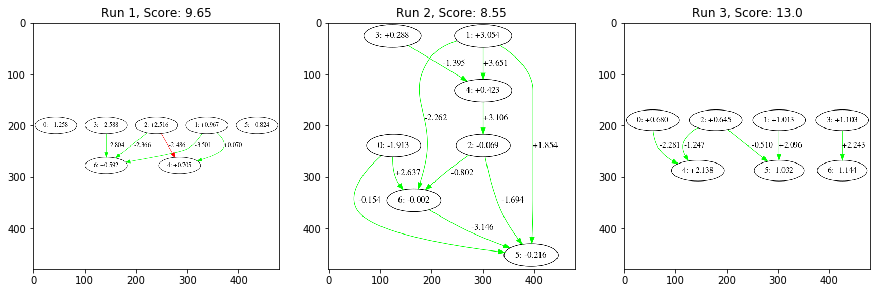

In [18]:
# Draw the best genomes each run
n_subplots = 3
cols = 3
rows = n_subplots // cols + n_subplots % cols

plt_position = range(1, n_subplots + 1)

fig = plt.figure(1, figsize=(15, 5))
for k in range(n_subplots):
    genome = pickle.load(open(path_template.format(k + 1), 'rb'))
    graph = genome_to_networkx(genome)
    
    ax = fig.add_subplot(rows, cols, plt_position[k])
    
    graph = nx.drawing.nx_agraph.to_agraph(graph)
    graph.graph_attr['size'] = '5!, 5!'
    graph.graph_attr['ratio'] = 'compress'
    graph.layout('dot')
    graph.draw('graph.png')
    
    # Pad image
    img = Image.open('graph.png')
    img = np.array(img)
    img = pad(img, 480)
    
    # Pad image
    img = np.array(img)
    
    plt.title(f'Run {k + 1}, Score: {genome.fitness}')
    plt.imshow(img)
    
plt.show()

**Notes**

* There is a significant amount of variability in the evolved solutions.
* Weights and biases appear to be mostly in the range [-3, 3].

## Behaviour

Visualise the behaviour of the evolved solutions.

In [30]:
path_template = BASE_DIR + '/run_{}/solution.pickle'

In [31]:
# Build environment
env = AtariARIWrapper(gym.make('Pong-v4'))

output_to_action = {
    0: 0,  # NOOP
    1: 2,  # RIGHT
    2: 3  # LEFT
}

# Store image for an episode for each solution
episodes = {}
for i in range(1, 4):
    images = []

    # Build network
    genome = pickle.load(open(path_template.format(i), 'rb'))
    network = RNN.create(genome)

    img = env.reset()
    images.append(img)
    img, reward, done, state = env.step(0)
    images.append(img)
    network.reset()

    while not done:

        obs = [state['labels']['player_x'],
                   state['labels']['player_y'],
                   state['labels']['enemy_x'],
                   state['labels']['enemy_y'],
                   state['labels']['ball_x'],
                   state['labels']['ball_y']]

        # Normalise inputs in the range [0, 1]
        obs[0] = (obs[0] - 0) / (205 - 0)    # player x
        obs[1] = (obs[1] - 38) / (203 - 38)  # player y
        obs[2] = (obs[2] - 0) / (205 - 0)    # enemy x
        obs[3] = (obs[3] - 38) / (203 - 38)  # enemy y
        obs[4] = (obs[4] - 0) / (205 - 0)    # ball x
        obs[5] = (obs[5] - 44) / (207 - 44)  # ball y

        output = network.forward(obs)
        action = output_to_action[np.argmax(output)]

        img, reward, done, state = env.step(action)
        images.append(img)
        
    episodes[i] = images

env.close()

In [32]:
# Pad shorter episodes with white frames
max_frames = max([len(e) for e in episodes.values()])
for run in episodes.keys():
    frames_needed = max_frames + 1 - len(episodes[run])
    extra_frames = [np.ones(episodes[run][0].shape)] * frames_needed
    episodes[run] = episodes[run] + extra_frames

In [33]:
max_frames + 1

4624

In [34]:
i = 0
def make_frame(t):
    global i
    
    if i < max_frames + 1:
        frames = np.array([episodes[k][i] for k in sorted(episodes.keys())])
        frame = np.hstack(frames)
        
        i += 1
        return frame

In [35]:
%%capture
clip = mpy.VideoClip(make_frame, duration=np.floor((max_frames + 1) / 30))
clip.write_videofile('temp.mp4', codec="mpeg4", fps=30)

In [36]:
%%capture
!ffmpeg -i temp.mp4 agents.mp4 -y

In [37]:
Video('agents.mp4')

## Speciation

In [27]:
# Load population checkpoints
populations = []
for filename in os.listdir(BASE_DIR + 'run_1/checkpoints/'):
    population = neat.Checkpointer.restore_checkpoint(BASE_DIR + 'run_1/checkpoints/' + filename)
    populations.append(population)
    
populations.sort(key=lambda x: x.generation)

In [28]:
# Speciate population according to parameters used in run
config = CustomConfig(Genome,
                      Reproduction,
                      SpeciesSet,
                      neat.DefaultStagnation,
                      'pong_config.ini')

config.species_set_config.compatibility_threshold = 4.0
config.genome_config.compatibility_disjoint_coefficient = 1.0
config.genome_config.compatibility_weight_coefficient = 3.0

species_set = SpeciesSet(config.species_set_config, neat.reporting.BaseReporter())
species_set.speciate(config, populations[0].population, generation=0)

print(f'Population divided into {len(species_set.species)} species.')

Population divided into 95 species.


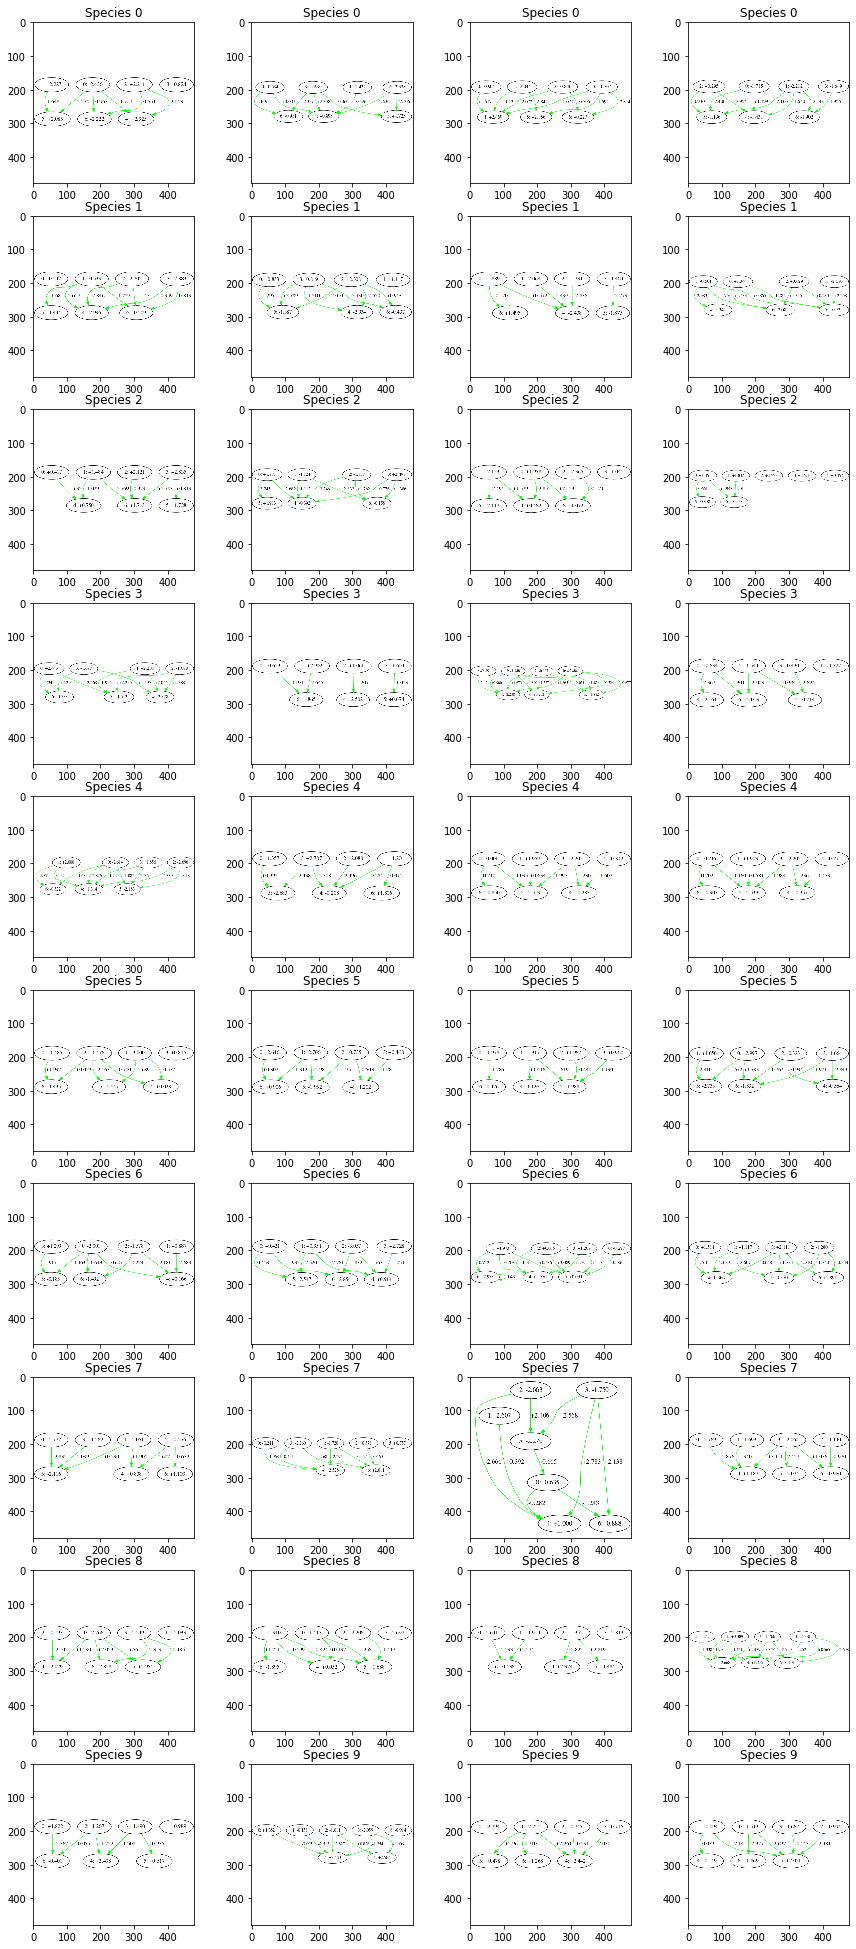

In [29]:
# Visualise 4 members of each species
n_species = 10
n_genomes = 4

n_subplots = n_species * n_genomes
cols = n_genomes
rows = n_subplots // cols + n_subplots % cols

plt_position = range(1, n_subplots + 1)

fig = plt.figure(1, figsize=(15, 35))
for i in range(n_species):
    species = species_set.species[i]
    genomes = list(species.members.values())
    for j in range(n_genomes):
        k = i * n_genomes + j
        if j < len(genomes):
            genome = genomes[j]
            graph = genome_to_networkx(genome)

            ax = fig.add_subplot(rows, cols, plt_position[k])

            graph = nx.drawing.nx_agraph.to_agraph(graph)
            graph.graph_attr['size'] = '5!, 5!'
            graph.graph_attr['ratio'] = 'compress'
            graph.layout('dot')
            graph.draw('graph.png')

            # Pad image
            img = Image.open('graph.png')
            img = np.array(img)
            img = pad(img, 480)

            # Pad image
            img = np.array(img)

            plt.title(f'Species {i}')
            plt.imshow(img)
    
plt.show()

**Notes**

* Speciation seems to be working well in grouping genomes of similar structures together.